# Compound Binds Gene Edge Prediction

This notebook is designed to take the next step moving from predicted sentences to edge predictions. After training the discriminator model, each sentences contains a confidence score for the likelihood of mentioning a relationship. Multiple relationships contain multiple sentences, which makes establishing an edge unintuitive. Is taking the max score appropiate for determining existence of an edge? Does taking the mean of each relationship make more sense? The answer towards these questions are shown below.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as p9
from tqdm import tqdm_notebook

In [2]:
total_candidates_df = (
    pd
    .read_csv("../dataset_statistics/results/all_cbg_candidates.tsv.xz", sep="\t")
    .sort_values("candidate_id")
)
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,drugbank_id,name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
817507,3630,INS,DB01124,Tolbutamide,NaN,0,621,1,0.42709,6,1.0,0.0,1.0,613126,Plasma insulin response to intravenous tolbuta...,12,50493
1864368,2520,GAST,DB00183,Pentagastrin,NaN,0,137,1,0.84974,7,1.0,0.0,1.0,486392,The effect of magnesium on calcium- and pentag...,22,50494


In [3]:
sentence_prediction_df = (
    pd
    .read_csv("input/all_predicted_cbg_sentences.tsv.xz", sep="\t")
    .drop_duplicates()
    .sort_values("candidate_id")
)
sentence_prediction_df.head(2)

,candidate_id,pred
0,50493,0.843225
1,50494,0.086004


In [4]:
# DataFrame that combines likelihood scores with each candidate sentence
total_candidates_pred_df = (
    total_candidates_df[[
    "drugbank_id", "name", 
    "entrez_gene_id", "gene_symbol", 
    "text", "hetionet",
    "candidate_id", "split"
    ]]
    .rename(index=str, columns={"name": "drug_name"})
    .merge(sentence_prediction_df, on="candidate_id")
)

total_candidates_pred_df.to_csv(
    "output/combined_predicted_cbg_sentences.tsv.xz", 
    sep="\t", index=False, compression="xz"
)

total_candidates_pred_df.head(2)

,drugbank_id,drug_name,entrez_gene_id,gene_symbol,text,hetionet,candidate_id,split,pred
0,DB01124,Tolbutamide,3630,INS,Plasma insulin response to intravenous tolbuta...,0,50493,6,0.843225
1,DB00183,Pentagastrin,2520,GAST,The effect of magnesium on calcium- and pentag...,0,50494,7,0.086004


In [5]:
# DataFrame that groups compound and gene mentions together and takes
# the max, median and mean of each group
grouped_candidates_pred_df=(
    total_candidates_pred_df
    .groupby(["drugbank_id", "entrez_gene_id"], as_index=False)
    .agg({
        "pred": ['max', 'mean', 'median'], 
        'hetionet': 'max',
        "gene_symbol": 'first',
        "drug_name": 'first',
        'split':'first'
    })
)
grouped_candidates_pred_df.head(2)

drugbank_id entrez_gene_id      pred                     hetionet  \
                                   max      mean    median      max   
0     DB00001            462  0.055028  0.055028  0.055028        0   
1     DB00001           2147  0.826480  0.501209  0.667084        1   

  gene_symbol  drug_name split  
        first      first first  
0    SERPINC1  Lepirudin     6  
1          F2  Lepirudin     8

In [6]:
grouped_candidates_pred_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'drug_name', 'split'] else col[0] 
    for col in grouped_candidates_pred_df.columns.values
]
grouped_candidates_pred_df.head(2)

,drugbank_id,entrez_gene_id,pred_max,pred_mean,pred_median,hetionet,gene_symbol,drug_name,split
0,DB00001,462,0.055028,0.055028,0.055028,0,SERPINC1,Lepirudin,6
1,DB00001,2147,0.826480,0.501209,0.667084,1,F2,Lepirudin,8


In [7]:
grouped_candidates_pred_subset_df = (
    grouped_candidates_pred_df
    .query("split==8")
    .drop("split", axis=1)
)
grouped_candidates_pred_subset_df.head(2)

,drugbank_id,entrez_gene_id,pred_max,pred_mean,pred_median,hetionet,gene_symbol,drug_name
1,DB00001,2147,0.826480,0.501209,0.667084,1,F2,Lepirudin
9,DB00007,596,0.574616,0.574616,0.574616,0,BCL2,Leuprolide


In [8]:
grouped_candidates_pred_subset_df.hetionet.value_counts()

0    20552
1      533
Name: hetionet, dtype: int64

# Best Sentence Representation Metric

This section aims to answer the question: What metric (Mean, Max, Median) best predicts Hetionet Edges?

In [9]:
performance_map = {}

In [10]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_max,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_max,
)

performance_map['max'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [11]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_mean,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_mean,
)

performance_map['mean'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [12]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_median,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_median,
)

performance_map['median'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

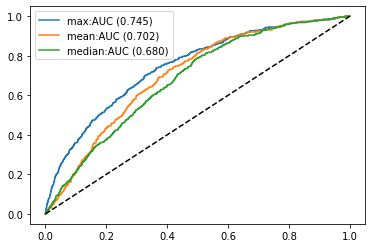

In [13]:
for key in performance_map:
    plt.plot(
        performance_map[key]['false_pos'], 
        performance_map[key]['true_pos'], 
        label=f"{key}:AUC ({auc(performance_map[key]['false_pos'], performance_map[key]['true_pos']):.3f})"
    )
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.legend()
plt.show()

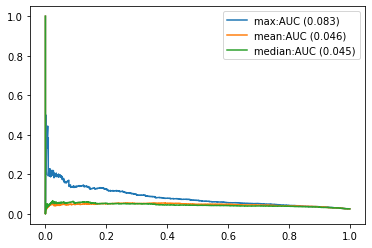

In [14]:
for key in performance_map:
    plt.plot(
        performance_map[key]['recall'], 
        performance_map[key]['precision'], 
        label=f"{key}:AUC ({auc(performance_map[key]['recall'], performance_map[key]['precision']):.3f})"
    )

plt.legend()
plt.show()

# Optimal Cutoff Using PR-CURVE 

In [15]:
threshold_df = (
    pd.DataFrame(
        list(
            zip(
                performance_map['max']['precision'], 
                performance_map['max']['recall'], 
                performance_map['max']['pr_threshold']
            )
        ),
        columns=["precision", "recall", "pr_threshold"]
    )
    .sort_values("precision", ascending=False)
)
threshold_df.head(2)

,precision,recall,pr_threshold
20783,0.500000,0.001876,0.982158
20776,0.444444,0.007505,0.973740


In [16]:
#precision_thresholds = pd.np.linspace(0,1,num=5)
precision_thresholds = threshold_df.round(2).drop_duplicates("precision").precision.values

# Add the lowest precision rather than
# Keep it zero
precision_thresholds = (
    pd.np.where(
        precision_thresholds==0, 
        threshold_df.query("precision > 0").precision.min(), 
        precision_thresholds
    )
)

performance_records = []
for precision_cutoff in tqdm_notebook(precision_thresholds):

    cutoff = (
        threshold_df
        .query("precision>=@precision_cutoff")
        .pr_threshold
        .min()
    )
    
    values_added = (
        grouped_candidates_pred_subset_df
        .query("pred_max >= @cutoff")
        .hetionet
        .value_counts()
    )
    
    series_keys = list(values_added.keys())
    for key in series_keys:
        performance_records.append(
           {  
               "edges": values_added[key], 
               "in_hetionet": "Existing" if key == 1 else "Novel", 
               "precision": precision_cutoff,
               "sen_cutoff": cutoff
           }
        )
   
    
edges_added_df = (
    pd
    .DataFrame
    .from_records(performance_records)
)
edges_added_df.head(10)

/home/danich1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


,edges,in_hetionet,precision,sen_cutoff
0,1,Existing,0.50,0.982158
1,1,Novel,0.50,0.982158
2,5,Novel,0.44,0.973740
3,4,Existing,0.44,0.973740
4,5,Novel,0.43,0.973740
5,4,Existing,0.43,0.973740
6,6,Novel,0.40,0.973554
7,4,Existing,0.40,0.973554
8,8,Novel,0.38,0.971480
9,5,Existing,0.38,0.971480


[None]

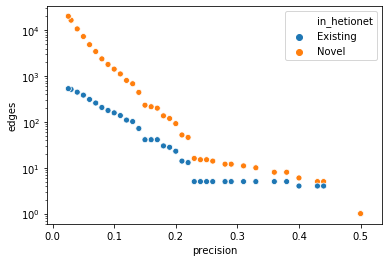

In [17]:
ax = sns.scatterplot(x="precision", y="edges", hue="in_hetionet", data=edges_added_df)
ax.set(yscale="log")

In [18]:
edges_added_df.to_csv("output/precision_cbg_edges_added.tsv", index=False, sep="\t")

# Total Recalled Edges

How many edges of hetionet can we recall using a cutoff score of 0.5?

In [19]:
datarows = []
datarows.append({
    "recall":(
        grouped_candidates_pred_df
        .query("pred_max > 0.5")
        .hetionet
        .value_counts()[1] /
        grouped_candidates_pred_df
        .hetionet.
        value_counts()[1]
    ),
    "edges":(
        grouped_candidates_pred_df
        .query("pred_max > 0.5")
        .hetionet
        .value_counts()[1]
    ),
    "in_hetionet": "Existing",
    "total": int(grouped_candidates_pred_df.hetionet.value_counts()[1]),
    "relation":"CbG"
})
datarows.append({
    "edges":(
        grouped_candidates_pred_df
        .query("pred_max > 0.5")
        .hetionet
        .value_counts()[0]
    ),
    "in_hetionet": "Novel",
    "relation":"CbG"
})
edges_df = pd.DataFrame.from_records(datarows)
edges_df

,edges,in_hetionet,recall,relation,total
0,3075,Existing,0.584157,CbG,5264.0
1,48022,Novel,NaN,CbG,NaN


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


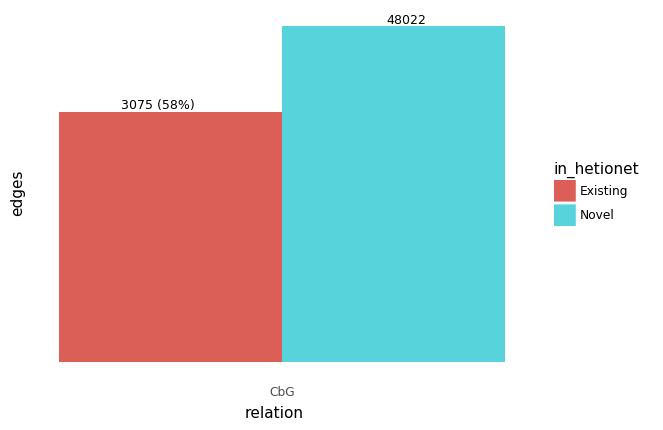

<ggplot: (-9223363265809882501)>


In [20]:
import math
g = (
    p9.ggplot(edges_df, p9.aes(x="relation", y="edges", fill="in_hetionet"))
    + p9.geom_col(position="dodge")
    + p9.geom_text(
        p9.aes(
            label=(
                edges_df
                .apply(
                    lambda x: 
                    f"{x['edges']} ({x['recall']*100:.0f}%)" 
                    if not math.isnan(x['recall']) else 
                    f"{x['edges']}",
                    axis=1
                )
            )
        ),
        position=p9.position_dodge(width=1),
        size=9,
        va="bottom"
    )
    + p9.scale_y_log10()
    + p9.theme(
        axis_text_y=p9.element_blank(),
        axis_ticks_major = p9.element_blank(),
        rect=p9.element_blank()
    )
)
print(g)